# Object Detection in Google Colab with Fizyr Retinanet

Colab notebook providing steps taken to train a Keras/Tensorflow model of RetinaNet for object detection with a custom dataset.

It runs in Google Colab using [Fizyr implementation](https://github.com/fizyr/keras-retinanet) of RetinaNet in Keras.

# Environment Setup
Update keras. Download and install in Colab required packages and import libraries.

In [18]:
!pip install q keras==2.3.0

In [19]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5334 (delta 0), reused 0 (delta 0), pack-reused 5329
Receiving objects: 100% (5334/5334), 14.70 MiB | 39.71 MiB/s, done.
Resolving deltas: 100% (3551/3551), done.


In [20]:
%cd keras-retinanet/

!pip install .

/content/keras-retinanet/keras-retinanet
Processing /content/keras-retinanet/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=169833 sha256=7f63be6ef44410ef3d6f392ab8c8f1834ea884e9be5e9fbbab62af5f8ef744a3
  Stored in directory: /root/.cache/pip/wheels/cd/57/f4/f71ed948102bf00ffcf4eed03f64026c8935c9e71edfb34035
Successfully built keras-retinanet
  Found existing installation: keras-retinanet 0.5.1
    Uninstalling keras-retinanet-0.5.1:
      Successfully uninstalled keras-retinanet-0.5.1


In [21]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/ut

# Import CSV Data from Google Drive

In [0]:
import os
import shutil
import zipfile
import urllib
import xml.etree.ElementTree as ET
import numpy as np
import csv
import pandas as pd
from google.colab import drive
from google.colab import files

In [23]:
!pip install PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import drive as dv
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Make Google Drive data accesible by rest of file and download the two csv files


In [35]:
dv.mount('/content/drive')

Mounted at /content/drive


In [0]:
downloaded_train = drive.CreateFile({'id':"1NQg0ev-eGJeLwF2m5tzsb6ACc18mVHJx"})   # replace the id with id of file you want to access
downloaded_train.GetContentFile('RetinaNetTrainData2.csv') 

downloaded_classes = drive.CreateFile({'id':"1J8o9UgMIyph5D0hfBaVZ1sxVzDOm3irh"})   # replace the id with id of file you want to access
downloaded_classes.GetContentFile('RetinaNetClasses.csv') 

In [0]:
train_data = pd.read_csv('RetinaNetTrainData2.csv', header=None)
class_data = pd.read_csv('RetinaNetClasses.csv', header=None)

In [29]:
train_data.head()

,0,1,2,3,4,5
0,/content/drive/My Drive/CityCam/410/410-201604...,159,73,178,85,vehicle
1,/content/drive/My Drive/CityCam/410/410-201604...,176,61,198,78,vehicle
2,/content/drive/My Drive/CityCam/410/410-201604...,260,71,294,96,vehicle
3,/content/drive/My Drive/CityCam/410/410-201604...,280,63,290,73,vehicle
4,/content/drive/My Drive/CityCam/410/410-201604...,306,94,327,113,vehicle


In [30]:
class_data.head()

,0,1
0,vehicle,0
1,passengers,1


# Training Model

Download pretrained model and run training.

In the next cell choose one option:

1.   download Fizyr Resnet50 pretrained model
2.   download your custom pretrained model, to continue previous training epochs

In the last cell optionally export trained model to Google Drive.


In [36]:
PRETRAINED_MODEL = 'snapshots/_pretrained_model.h5'

#### OPTION 1: DOWNLOAD INITIAL PRETRAINED MODEL FROM FIZYR ####
#URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
#urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

#### OPTION 2: DOWNLOAD CUSTOM PRETRAINED MODEL FROM GOOGLE DRIVE. CHANGE DRIVE_MODEL VALUE. USE THIS TO CONTINUE PREVIOUS TRAINING EPOCHS ####
dv.mount('/content/drive')
DRIVE_MODEL = '/content/drive/My Drive/resnet50_csv_10.h5'
shutil.copy(DRIVE_MODEL, PRETRAINED_MODEL)


print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Downloaded pretrained model to snapshots/_pretrained_model.h5


In [0]:
#!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 1095 --epochs 10 --snapshot-path snapshots csv RetinaNetTrainData2.csv RetinaNetClasses.csv

Using TensorFlow backend.
Creating model, this may take a second...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

2019-11-13 15:54:26.416001: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-11-13 15:54:26.462907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-11-13 15:54:26.463458: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:00:04.0
2019-11-13 15:54:26.471834: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2019-11-13 15:54:26.681074: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library 

## Model Architecture

Below is a screenshot of the entire network architecture used to train this model. This RetinaNet model was created by the company Fizyr. We began training based on the resnet50 pretrained model on the Coco dataset to make the training process faster. 

![test](https://docs.google.com/uc?export=download&id=14neot_K_IYfMZjqb6hbq42cC_Xp52j2_)
![test](https://docs.google.com/uc?export=download&id=1om4IJPndMZf56PdvBOoCCDXaqSBEg_1W)
![test](https://docs.google.com/uc?export=download&id=1HonRsi0tXgxr4xmD1BczBvZAn4sSZe-J)
![test](https://docs.google.com/uc?export=download&id=1L9ZKyqvadfrVyvMCMeJTmRrGL8DWx6tj)
![test](https://docs.google.com/uc?export=download&id=1Q8aHbxuPA13yCA0f7yw8pBFxl0nIPGDh)
![test](https://docs.google.com/uc?export=download&id=1Vby8NRnqDPJgKDOL0q8GNGol-xfnt6ta)
![test](https://docs.google.com/uc?export=download&id=1LcddmKzj3u50rPz94jV4Ly_RvkP5YHRw)
![test](https://docs.google.com/uc?export=download&id=1CLxb2whAZEdszQ9_EddPExhKnc7oRqf4)
![test](https://docs.google.com/uc?export=download&id=1_gvDIiKM81754R1gUVJndpUJBwyAwDPy)
![test](https://docs.google.com/uc?export=download&id=1z3Y8cUjOdJSWYQh9wTCS-5yEPAL_oFrr)



### Training Results:



Below are screenshots of the loss function updating over each epoch on the second round of training the model on the second half of the dataset:

![test](https://docs.google.com/uc?export=download&id=17Fyf-kwD2SSxYEILbMDKJghxR-KlNxlL)
![test](https://docs.google.com/uc?export=download&id=1xhlzxRYYMLSlSI7FP955V_gJic5SbCdj)

In [32]:
#### EXPORT TRAINED MODEL TO DRIVE ####
dv.mount('/content/gdrive', force_remount=True)
COLAB_MODEL = './snapshots/resnet50_csv_10.h5'
DRIVE_DIR = '/content/gdrive/My Drive/'
shutil.copy(COLAB_MODEL, DRIVE_DIR)

Mounted at /content/gdrive


FileNotFoundError: ignored

In [0]:
!ls -a

.		 .git		  LICENSE		   setup.py
..		 .github	  README.md		   snapshots
build		 .gitignore	  requirements.txt	   tests
.codecov.yml	 .gitmodules	  RetinaNetClasses.csv	   .travis.yml
CONTRIBUTORS.md  images		  RetinaNetTrainData2.csv
examples	 keras_retinanet  setup.cfg


In [0]:
from keras_retinanet import models
import os

model_path = 'snapshots/_pretrained_model.h5'
model = models.load_model(model_path, backbone_name='resnet50')

# Inference
Running inference with an image that was NOT used to train this model (only the first 200 pictures of each folder were used to train the model).

In [37]:
print(model.output_names)
print(model.output_shape)

NameError: ignored

In [0]:
#Set threshold to only pick up bounding boxes ABOVE a certain confidence level.
THRES_SCORE = 0.4

In [39]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%reload_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


In [40]:
import pandas
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

# load label to names mapping for visualization purposes
labels_to_names = pandas.read_csv('RetinaNetClasses.csv',header=None).T.loc[0].to_dict()

snapshots/_pretrained_model.h5
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors


In [0]:
def img_inference(img_path):
  image = read_image_bgr(img_infer)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  start = time.time()
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  #print(boxes)
  #print('***********************')
  #print(scores)
  #print('***********************')
  #print(labels)
  #print("processing time: ", time.time() - start)

  # correct for image scale
  boxes /= scale

  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      if score < THRES_SCORE:
          break

      color = label_color(label)

      b = box.astype(int)
      draw_box(draw, b, color=color)

      caption = "{} {:.3f}".format(labels_to_names[label], score)
      draw_caption(draw, b, caption)

  plt.figure(figsize=(10, 10))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()
  return boxes, scores, labels, draw

Saving 000005.jpg to 000005 (2).jpg
Original Image:


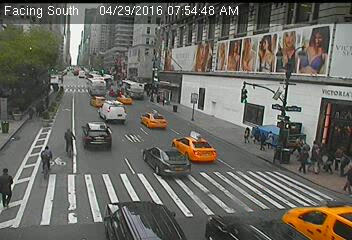

Running inference on: 000005.jpg
[[[568.5875  450.30768 725.83124 546.46405]
  [463.67172 374.31522 558.6232  430.96378]
  [473.39752 485.7396  637.5404  594.4081 ]
  ...
  [671.63763 737.56866 719.67035 800.     ]
  [310.36887 313.42535 356.89307 341.76196]
  [125.59858 359.82605 177.09108 428.9947 ]]]
***********************
[[0.9963474  0.9901743  0.98897886 0.97660244 0.9538524  0.9038558
  0.8881496  0.8529237  0.8155122  0.7361283  0.72285247 0.70809776
  0.69116515 0.66754293 0.5973555  0.5053765  0.4550773  0.43960816
  0.43270683 0.4261384  0.4218964  0.40423468 0.3952819  0.39396185
  0.3929057  0.39128    0.3871166  0.34435642 0.32895905 0.32673758
  0.32565647 0.31484395 0.3123278  0.28890598 0.28101194 0.27186
  0.2647909  0.26415876 0.2597136  0.25448984 0.24883682 0.24798742
  0.24375278 0.24248189 0.24229935 0.23403162 0.22104833 0.21873051
  0.21746063 0.20126206 0.19928321 0.19827592 0.19247723 0.19085205
  0.19043672 0.18696827 0.18627238 0.186212   0.18218172 0.1814

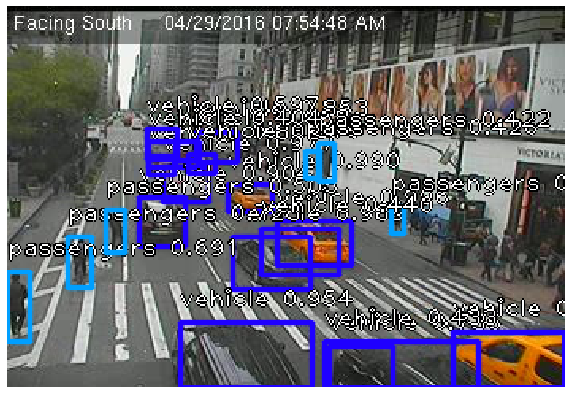

In [59]:
from IPython.display import Image, display
uploaded = files.upload()

img_infer = list(uploaded)[0]

print("Original Image:")
display(Image(img_infer,width=560,height=350))

print('Running inference on: ' + img_infer)
bboxes, scores, labels = img_inference(img_infer)

## Make the model look like a GIF

In [105]:
uploaded = files.upload()
img_infer = list(uploaded)[1]
print(img_infer)

Saving 000001.jpg to 000001 (6).jpg
Saving 000002.jpg to 000002 (6).jpg
000002.jpg


In [95]:
!ls "/content/drive/My Drive/CityCam/170/170-20160425-18"

000001.jpg  000051.jpg	000101.jpg  000151.jpg	000201.jpg  000251.jpg
000001.xml  000051.xml	000101.xml  000151.xml	000201.xml  000251.xml
000002.jpg  000052.jpg	000102.jpg  000152.jpg	000202.jpg  000252.jpg
000002.xml  000052.xml	000102.xml  000152.xml	000202.xml  000252.xml
000003.jpg  000053.jpg	000103.jpg  000153.jpg	000203.jpg  000253.jpg
000003.xml  000053.xml	000103.xml  000153.xml	000203.xml  000253.xml
000004.jpg  000054.jpg	000104.jpg  000154.jpg	000204.jpg  000254.jpg
000004.xml  000054.xml	000104.xml  000154.xml	000204.xml  000254.xml
000005.jpg  000055.jpg	000105.jpg  000155.jpg	000205.jpg  000255.jpg
000005.xml  000055.xml	000105.xml  000155.xml	000205.xml  000255.xml
000006.jpg  000056.jpg	000106.jpg  000156.jpg	000206.jpg  000256.jpg
000006.xml  000056.xml	000106.xml  000156.xml	000206.xml  000256.xml
000007.jpg  000057.jpg	000107.jpg  000157.jpg	000207.jpg  000257.jpg
000007.xml  000057.xml	000107.xml  000157.xml	000207.xml  000257.xml
000008.jpg  000058.jpg	000108.jpg 

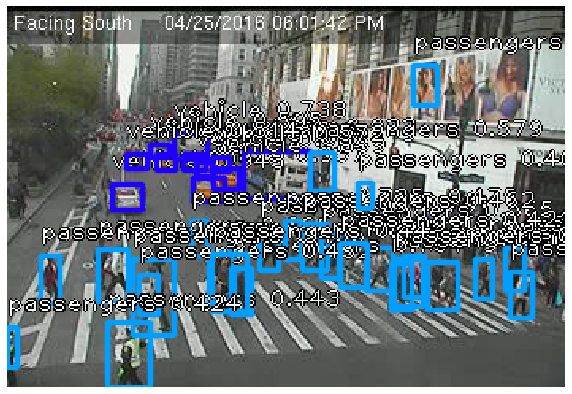

In [117]:
from IPython import display


i = 0
uploaded = files.upload()

for i in uploaded:
  img_infer = i
  bboxes, scores, labels, image = img_inference(img_infer)

  display.clear_output(wait=True)
  #display.display(image)

  time.sleep(1.0)


# Evaluate Model using Test Data

In [89]:
dv.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
downloaded_train = drive.CreateFile({'id':"14u-0P20jj4ta4OYrQihXIFHtWMSQWhYj"})   # replace the id with id of file you want to access
downloaded_train.GetContentFile('RetinaNetTestData.csv') 
test_data = pd.read_csv('RetinaNetTestData.csv', header=None)
test_data.head()

,0,1,2,3,4,5
0,/content/drive/My Drive/CityCam/410/410-201604...,174,61,199,79,vehicle
1,/content/drive/My Drive/CityCam/410/410-201604...,134,124,177,160,vehicle
2,/content/drive/My Drive/CityCam/410/410-201604...,304,95,329,113,vehicle
3,/content/drive/My Drive/CityCam/410/410-201604...,290,82,308,96,vehicle
4,/content/drive/My Drive/CityCam/410/410-201604...,295,56,311,84,vehicle


In [43]:
#Convert the training model to an inference model
!keras_retinanet/bin/convert_model.py snapshots/_pretrained_model.h5 snapshots/_inference_model.h5

Using TensorFlow backend.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

2019-11-13 20:06:27.817847: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-11-13 20:06:27.820334: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2019-11-13 20:06:27.820396: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 03c1f678d788
2019-11-13 20:06:27.820407: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 03c1f678d788
2019-11-13 20:06:27.820496: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 418.67.0
2019-11-13 20:06:27.820527: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 418.67.0
2019-11-13 20:06:27.820535: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc

In [44]:
#Run evaluation script
!keras_retinanet/bin/evaluate.py csv RetinaNetTestData.csv RetinaNetClasses.csv snapshots/_inference_model.h5

Using TensorFlow backend.
Loading model, this may take a second...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
2019-11-13 20:07:52.430051: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-11-13 20:07:52.432755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-11-13 20:07:52.433286: I ten

## Evaluation Results:

![test](https://docs.google.com/uc?export=download&id=1-Sued7F5DsP8AtYj4du6ZEhhNKgeGfpu)

147 images were passed through the neural network in 47 seconds with precision of classes vehicle and passenger calculated. Inference time totaled 0.3005 seconds for the 147 images.

**Precision of class Vehicle over 2677 instances**: ~90% 

**Precision of class Passenger over 200 instances**: ~82%

**mAP**: ~86%

Our model is more precise at detecting vehicles than pedestrians. Based on the inference above, it is precise enough to predict roughly the amount of cars and pedestrians at any given crosswalk.



## Traffic Light Algorithm

In [66]:
bboxes.shape

(1, 300, 4)

In [79]:
labels

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
        1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 

In [76]:
print(scores[0][5])

0.9038558


In [83]:
#count people
personCount = 0
i = 0
index_of_people = []
for labelHead in labels:
  for label in labelHead:
    if label == 1:
      if scores[0][i] > THRES_SCORE:
        personCount += 1
        index_of_people.append(i)
    i += 1
print(personCount)
print(index_of_people)

6
[10, 12, 15, 16, 19, 20]


In [84]:
#count vehicles
vehicleCount = 0
i = 0
index_of_vehicles = []
for labelHead in labels:
  for label in labelHead:
    if label == 0:
      if scores[0][i] > THRES_SCORE:
        vehicleCount += 1
        index_of_vehicles.append(i)
    i += 1
print(vehicleCount)
print(index_of_vehicles)

16
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 17, 18, 21]


# Cross Walk Detection
We now need to use a segmentation algorithm to detect lines of the crosswalk.

I will begin by attempting to use both the Hough transform and the Probabilistic Hough transform in order to find the lines.


Saving 000004.jpg to 000004 (10).jpg
000004.jpg
Source:


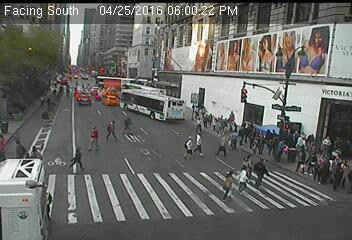

Hough Line Transform:


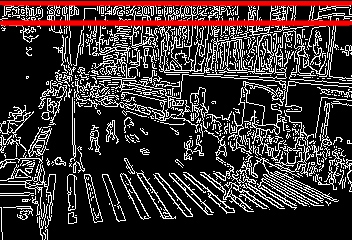

Probabilistic Hough Line Transform:


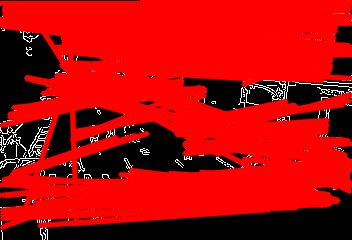

-1

In [0]:
# method for line detection 
import cv2 
import numpy as np 
from google.colab import files
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import math

uploaded = files.upload()
for fn in uploaded.keys():
  name = fn
print(name)
img = Image.open(BytesIO(uploaded[name]))

open_cv_image = np.array(img) 
# Convert RGB to BGR 
open_cv_image = open_cv_image[:, :, ::-1].copy() 
  

dst = cv2.Canny(open_cv_image, 50, 200, None, 3)
    
# Copy edges to the images that will display the results in BGR
cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)
    
lines = cv2.HoughLines(dst, 1, np.pi / 180, 150, None, 0, 0)
    
if lines is not None:
  for i in range(0, len(lines)):
    rho = lines[i][0][0]
    theta = lines[i][0][1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(cdst, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)
    
    
linesP = cv2.HoughLinesP(dst, 1, np.pi / 180, 50, 200, 100, 20)
    
if linesP is not None:
  for i in range(0, len(linesP)):
    l = linesP[i][0]
    cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)
    
print("Source:")
cv2_imshow(open_cv_image)
print("Hough Line Transform:")
cv2_imshow(cdst)
print("Probabilistic Hough Line Transform:")
cv2_imshow(cdstP)
    
cv2.waitKey()


Although the probabilistic hough transform detects the crosswalk, there is way too much noise and variability in our images to effectively predict a crosswalk using this form of edge detection. Another Neural Network may need to be trained in order to detect the location of crosswalks in an image. 